# LSTM Production
Notebook to put LSTM into production on AWS

In [88]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import sqlalchemy
from sqlalchemy import create_engine
import s3fs
import gc

from functools import partial
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.stopper import TrialPlateauStopper

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from bgpredict.helpers import S3Connection

from dotenv import load_dotenv

ModuleNotFoundError: No module named 'bgpredict'

### Model

In [2]:
class Net(nn.Module):
    
    def __init__(self, input_size=30, hidden_size=8, num_lstm_layers=1, dropout=0):
        super().__init__()
        if num_lstm_layers == 1:
            dropout = 0
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        return x

### Train Function

In [18]:
def train_lstm(config, train_X, train_y, val_X, val_y, checkpoint_dir=None,):

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    
    print(f"DEVICE: {device}")
    # train_X = train_X.to(device)
    # train_y = train_y.to(device)
    # val_X = val_X.to(device)
    # val_y = val_y.to(device)
    
    # Configure the network and send it to the device
    # Width of the dataframe - 1 (y variable) is feature set size 
    input_size = train_X.shape[2]
    net = Net(input_size=input_size,
              hidden_size=config['hidden_size'],
              num_lstm_layers=config['num_lstm_layers'],
              dropout=config['dropout'])
    
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)     
    net.to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'])
    optimizer
    
    # Checkpoint Dir Stuff -- handled by Tune 
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)    
    
    # train
    BATCH_SIZE = config['batch_size']
    for epoch in range(1000):
        epoch_start = datetime.now()
        print(f"Epoch: {epoch}")
        running_loss = 0
        epoch_steps = 0
        for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
            X = train_X[i:i+BATCH_SIZE].to(device)
            y = train_y[i:i+BATCH_SIZE].to(device)
            net.zero_grad()
            
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
            
            # Print loss every 1000 batches
            if i % 100 == 99:
                avg_loss = running_loss / epoch_steps
                print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
                running_loss = 0 
                
        # Validate each epoch
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
                X = val_X[i:i+BATCH_SIZE].to(device)
                y = val_y[i:i+BATCH_SIZE].to(device)
                out_seq = net(X)
                first_dim, second_dim, _ = out_seq.shape
                pred = out_seq.view(first_dim, second_dim)[:, -1]
                loss = F.mse_loss(pred, y)
                val_loss += loss.item()
                val_steps += 1
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(val_loss=(val_loss/val_steps), train_loss=(running_loss/epoch_steps), training_iteration=epoch)
        print(f"Finished epoch {epoch} in {datetime.now()-epoch_start}")
    print("finished!")

### Load and Process data

In [4]:
s3 = s3fs.S3FileSystem()
print("Loading train X")
with s3.open("s3://bgpredict/models/lstm/tensors/train_X", 'rb') as f:
    train_X=torch.load(f)
print("Loading train y")
with s3.open("s3://bgpredict/models/lstm/tensors/train_y", 'rb') as f:
    train_y=torch.load(f)
print("Loading Val X")
# with s3.open("s3://bgpredict/models/lstm/tensors/val_X", 'rb') as f:
#     val_X=torch.load(f)    
with open("./val_X.pt", 'rb') as f:
    val_X = torch.load(f)
print("Loading Val y")
# with s3.open("s3://bgpredict/models/lstm/tensors/val_y", 'rb') as f:
#     val_y=torch.load(f)    


Loading train X
Loading train y
Loading Val X
Loading Val y


In [9]:
with open("./val_y.pt", 'rb') as f:
    val_y = torch.load(f)

In [12]:
with open("./val_y.pt", 'wb') as f:
    torch.save(val_y, f) 

In [18]:
with open("./val_X.pt", 'wb') as f:
    torch.save(val_X, f) 

In [23]:
# with open("./train_X.pt", 'wb') as f:
#     torch.save(train_X, f)

In [ ]:
with open("./train_y.pt", 'wb') as f:
    torch.save(train_y, f)

In [10]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

torch.Size([2822590, 12, 171])
torch.Size([2822590])
torch.Size([1346613, 12, 171])
torch.Size([1346613])


In [13]:
torch.cuda.is_available()

True

In [23]:
ray.shutdown()
ray.init(local_mode=True)

2022-07-28 21:35:57,409	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.31.45.32', 'raylet_ip_address': '172.31.45.32', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-28_21-35-53_631155_18603/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-28_21-35-53_631155_18603/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-07-28_21-35-53_631155_18603', 'metrics_export_port': 61451, 'gcs_address': '172.31.45.32:58624', 'address': '172.31.45.32:58624', 'node_id': '6b8d98ec4f224e5e1dafe37876cd3c8d610000a126156da0d8a4fc02'})

In [22]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [24]:
import gc 
gc.collect()

1039

In [ ]:
config= {
    'hidden_size': tune.choice([2**x for x in range(3, 8)]), # 2^3 to 2^8, 8 to 256
    'num_lstm_layers':tune.choice([1,2,3]),
    'dropout': tune.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5]), # [0,0.5]
    'learning_rate': tune.choice([0.00001, 0.0001, 0.001, 0.01, 0.1]),
    'batch_size': tune.choice([128]) #tune.choice([2**x for x in range(3, 9)]), # 2^3 to 2^8, 8 to 256
}

initial_params = [{"hidden_size": 128,
                  "num_lstm_layers": 1,
                  "dropout": 0,
                  "batch_size": 256,
                  'learning_rate': 0.1}]

def stopper(trial_id, result):
    gc.collect()
    if result['training_iteration'] > 100:
        return True
    elif result['val_loss'] < 5:
        return True
    else:
        return False


hyperopt_search = HyperOptSearch(metric='val_loss', mode='min', points_to_evaluate=initial_params)

scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    grace_period=3,
    max_t=200
)

reporter = JupyterNotebookReporter(
    metric_columns = ["val_loss", "loss", "training_iteration"],
    overwrite=False,
    max_report_frequency=60
)


result = tune.run(
    tune.with_parameters(
        train_lstm,
        train_X = train_X,
        train_y = train_y,
        val_X = val_X,
        val_y = val_y
    ),
    resources_per_trial={"cpu":0, "gpu":4},
    config=config,
    num_samples=1,
    progress_reporter=reporter,
    search_alg=hyperopt_search,
    name='GPU',
    stop = stopper,
    resume=False
)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:457] ray.rpc.GetObjectStatusReply exceeded maximum protobuf size of 2GB: 23167819240
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:457] ray.rpc.GetObjectStatusReply exceeded maximum protobuf size of 2GB: 11053000024


:task_name:bundle_reservation_check_func


:task_name:bundle_reservation_check_func
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:457] ray.rpc.GetObjectStatusReply exceeded maximum protobuf size of 2GB: 23167819240
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:457] ray.rpc.GetObjectStatusReply exceeded maximum protobuf size of 2GB: 11053000024
[2022-07-28 21:38:35,624 E 18603 18603] core_worker.cc:1382: Pushed Error with JobID: 01000000 of type: pickling_large_object with message: Warning: The actor ImplicitFunc is very large (15 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store. at time: 1.65904e+09


:actor_name:ImplicitFunc
:actor_name:train_lstm


:actor_name:ImplicitFunc
:actor_name:train_lstm


DEVICE: cuda:0
Epoch: 0


2022-07-28 21:42:17,782	WARNING util.py:214 -- The `start_trial` operation took 243.524 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>
Result for train_lstm_959e5f2a:
  date: 2022-07-28_21-42-17
  done: false
  experiment_id: 0b7e0c285a244c06b7002950a8075fdd
  hostname: ip-172-31-45-32.us-west-2.compute.internal
  iterations_since_restore: 1
  node_ip: 172.31.45.32
  pid: 18603
  should_checkpoint: true
  time_since_restore: 221.880872964859
  time_this_iter_s: 221.880872964859
  time_total_s: 221.880872964859
  timestamp: 1659044537
  timesteps_since_restore: 0
  train_loss: 2622.000008099593
  training_iteration: 0
  trial_id: 959e5f2a
  val_loss: 3040.9449184113128
  warmup_time: 0.0012040138244628906
  
Finished epoch 0 in 0:02:52.544281
Epoch: 1
<IPython.core.display.HTML object>
Result for train_lstm_959e5f2a:
  date: 2022-07-28_21-44-39
  done: false
  experiment_id: 0b7e0c285a244c06b7002950a8075fdd
  hostname: ip-172-31-45-32.us-west-2.compute.internal
  iterations_since_restore: 2
  node_ip: 172.31.45.32
  pid: 18603
  should_checkpoint: true
  time_since_restore: 363.663691

In [1]:
# Tune Results

NameError: name 'result' is not defined

In [10]:
best_trial =result.get_best_trial(metric='val_loss', mode='min', scope="last-5-avg")

In [11]:
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))

Best trial config: {'hidden_size': 64, 'num_lstm_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 128}
Best trial final validation loss: 63.94800898437842


In [31]:
best_trial.

In [21]:
best_dir = result.get_best_logdir(metric='val_loss', mode='min')
df = pd.read_csv(f"{best_dir}/progress.csv")
print(f"{best_dir}/progress.csv")
min(df['val_loss'])

/home/ec2-user/ray_results/GPU_fixed/train_lstm_d9a6a7da_70_batch_size=128,dropout=0.1000,hidden_size=64,learning_rate=0.0010,num_lstm_layers=2_2022-07-30_08-59-54/progress.csv


42.80172475369401

(50.0, 200.0)

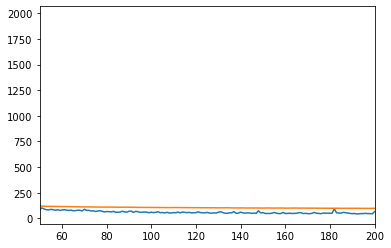

In [22]:
plt.plot(df['val_loss'])
plt.plot(df['train_loss'])
plt.xlim((50,200))

In [12]:
dfs = result.trial_dataframes

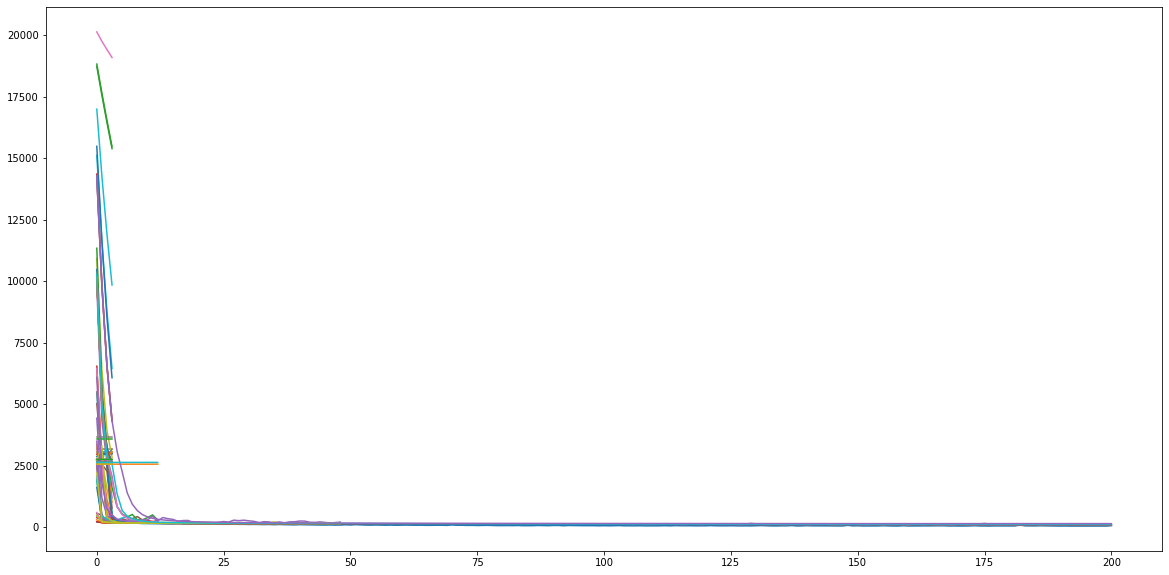

In [14]:
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False, figsize=(20,10))

# Manual Train

In [8]:
best_trial = {'hidden_size': 128, 'num_lstm_layers': 2, 'dropout': 0.3}
learning_rate = 0.001
BATCH_SIZE = 256

In [9]:
net = Net(input_size=train_X.shape[2], 
          hidden_size = best_trial['hidden_size'],
          num_lstm_layers=best_trial['num_lstm_layers'],
          dropout= best_trial['dropout']
)
net

Net(
  (lstm): LSTM(30, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
losses = []
val_losses = []
# BATCH_SIZE = best_trial['batch_size']
# learning_rate = best_trial['learning_rate']
iter_idx = 0 
running_loss = 0
running_val_loss = 0
epoch_steps = 0
epoch = 0 
SAVE_DIR = "./models"

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

print(f"DEVICE: {device}")
if torch.cuda.device_count() > 1:
    print(f"Running in Parallel on {torch.cuda.device_count()} GPU's")
    net = nn.DataParallel(net)     
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

DEVICE: cuda:0
Running in Parallel on 4 GPU's


In [11]:
train_X = train_X.to(device)
train_y = train_y.to(device)
val_X = val_X.to(device)
val_y = val_y.to(device)

In [12]:
while True:
    start = datetime.now()
    epoch_loss = []
    train_start = datetime.now()
    for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
        
        # X = train_X[i:i+BATCH_SIZE].to(device)
        # y = train_y[i:i+BATCH_SIZE].to(device)
        X = train_X[i:i+BATCH_SIZE]
        y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()

        out_seq = net(X)
        first_dim, second_dim, _ = out_seq.shape
        pred = out_seq.view(first_dim, second_dim)[:, -1]
        loss = F.mse_loss(pred, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * BATCH_SIZE
        epoch_steps += 1
    print(f'Trained in {datetime.now() - train_start}')
    # Compute Epoch Training Loss
    epoch_train_loss = running_loss / train_X.shape[0]
    losses.append(epoch_train_loss)
    
    # Compute Validation Loss
    val_loss = []
    val_steps = 0
    val_start = datetime.now()
    with torch.no_grad():
        for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
            X = val_X[i:i+BATCH_SIZE]
            y = val_y[i:i+BATCH_SIZE]
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            running_val_loss += loss.item() * BATCH_SIZE
            val_steps += 1
    print(f'Validated in {datetime.now() - val_start}')
    # Compute validation loss
    epoch_val_loss = running_val_loss / val_X.shape[0]
    val_losses.append(epoch_val_loss)
        
    mean_trailing_loss = np.mean(val_losses[-10:])
    print('here')
    running_loss = 0 
    running_val_loss = 0 
    epoch_steps = 0 
    epoch += 1
        
    if epoch >=500:
        break
    save_string = f"{epoch}_{np.round(epoch_val_loss, 2)}.pth"
    torch.save(net.cpu().state_dict(), os.path.join(SAVE_DIR, save_string))
    net.to(device)
    
    # Print Results 
    print(f"Epoch {epoch} finished in {datetime.now()-start}| Train Loss: {epoch_train_loss} | Batch AVG(Validation) Loss: {epoch_val_loss} | Trailing Loss: {mean_trailing_loss}")   
    

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Trained in 0:01:09.585000
Validated in 0:00:16.090272
here
Epoch 1 finished in 0:01:25.679595| Train Loss: 3023.5986934124553 | Batch AVG(Validation) Loss: 777.8594603791373 | Trailing Loss: 777.8594603791373
Trained in 0:01:00.880796
Validated in 0:00:15.817707
here
Epoch 2 finished in 0:01:16.702866| Train Loss: 483.21686476218014 | Batch AVG(Validation) Loss: 218.50838457981595 | Trailing Loss: 498.1839224794766


KeyboardInterrupt: 

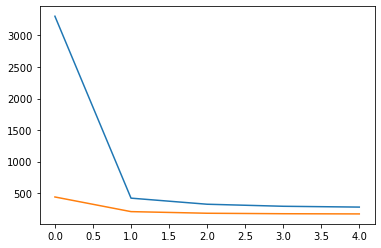

In [26]:
plt.plot(losses)
plt.plot(val_losses)

# Evaluate

## Load Best Tune Model

In [25]:
best_dir = result.get_best_logdir(metric='val_loss', mode='min')
df = pd.read_csv(f"{best_dir}/progress.csv")
df.loc[df['val_loss'] == min(df['val_loss']), :] # Gives index of best model

,val_loss,train_loss,training_iteration,time_this_iter_s,done,timesteps_total,episodes_total,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
192,42.801725,97.82075,192,52.395226,False,NaN,NaN,d9a6a7da,dc4708811efa4eb6a9e1fb90fa6e3eaa,2022-07-30_11-51-54,1659181914,10317.979286,8244,ip-172-31-11-119.us-west-2.compute.internal,172.31.11.119,10317.979286,0,193,0.002376


In [39]:
checkpoint = "checkpoint_000192/checkpoint"
state = torch.load(os.path.join(best_dir, checkpoint))
network_state_dict = state[0]

In [40]:
print(best_dir)
# Parameters need to be equal to those the model was called with. We can get thse from the directory path
parameters= {"input_size": 30, "hidden_size": 64, "num_lstm_layers": 2, "dropout": 0.1}
net = Net(**parameters)
net.load_state_dict(network_state_dict)

/home/ec2-user/ray_results/GPU_fixed/train_lstm_d9a6a7da_70_batch_size=128,dropout=0.1000,hidden_size=64,learning_rate=0.0010,num_lstm_layers=2_2022-07-30_08-59-54


<All keys matched successfully>

## Save Best Tune Model

In [72]:
# Save all checkpoints of best model
s3 = s3fs.S3FileSystem()
lstm = "s3://bgpredict/models/lstm/"
s3.put("/home/ec2-user/ray_results/GPU_fixed/train_lstm_d9a6a7da_70_batch_size=128,dropout=0.1000,hidden_size=64,learning_rate=0.0010,num_lstm_layers=2_2022-07-30_08-59-54",
       f"{lstm}best_model_dir",
       recursive =True
      )

In [91]:
# Save trial dataframes of tune results
trial_df_dir = f"{lstm}best_trial_dfs"
print(trial_df_dir)
for key, vals in dfs.items():
    model_name = key.split("/")[-1]
    vals_csv = vals.to_csv()
    location = f"{trial_df_dir}/{model_name}.csv"
    with s3.open(location, 'w') as f:
        f.write(vals_csv)

s3://bgpredict/models/lstm/best_trial_dfs


In [94]:
# Store model state dict in s3
best_model_dest = f"{lstm}best_model/best_opt_state_net_state"
best_model_src = os.path.join(best_dir, checkpoint)
print(best_model_src)
s3.put(best_model_src, best_model_dest)

/home/ec2-user/ray_results/GPU_fixed/train_lstm_d9a6a7da_70_batch_size=128,dropout=0.1000,hidden_size=64,learning_rate=0.0010,num_lstm_layers=2_2022-07-30_08-59-54/checkpoint_000192/checkpoint


In [97]:
# Validate Load
with s3.open(best_model_dest) as f:
    mod = torch.load(f)
print(mod[0].keys())

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc1.weight', 'fc1.bias'])


## Evaluate Test Set

In [41]:
with open("./test_X.pt", 'rb') as f:
    test_X = torch.load(f)
with open("./test_y.pt", 'rb') as f:
    test_y = torch.load(f)

In [44]:
net.eval()
with torch.no_grad():
    out_seq = net(test_X)
    first_dim, second_dim, _ = out_seq.shape
    pred = out_seq.view(first_dim, second_dim)[:, -1]

In [45]:
pred_array = pred.cpu().detach().numpy()
y = test_y.detach().numpy()

In [47]:
df = pd.DataFrame({"y_true":y, "y_hat": pred_array})
df = df.loc[df['y_true'] != 0, :]

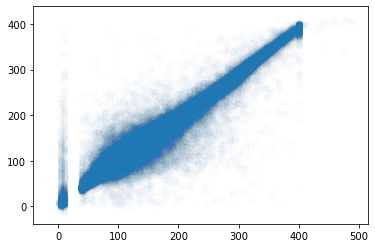

In [48]:
plt.scatter(df['y_true'], df['y_hat'], alpha=0.01)

In [49]:
r2_score(df["y_true"], df["y_hat"])

0.9735615829431856

In [50]:
mse = mean_squared_error(df["y_true"], df["y_hat"])
print(np.sqrt(mse))

8.326914


In [51]:
mean_absolute_percentage_error(df["y_true"], df["y_hat"])

0.04119041

In [52]:
mean_absolute_error(df["y_true"], df["y_hat"])

5.0135427

## Evaluate Holdout Set

In [54]:
with open("./holdout_X.pt", 'rb') as f:
    holdout_X = torch.load(f)
with open("./holdout_y.pt", 'rb') as f:
    holdout_y = torch.load(f)

In [63]:
net.eval()
with torch.no_grad():
    out_seq = net(holdout_X)
    first_dim, second_dim, _ = out_seq.shape
    pred = out_seq.view(first_dim, second_dim)[:, -1]

In [64]:
pred_array = pred.cpu().detach().numpy()
y = holdout_y.detach().numpy()

In [65]:
df = pd.DataFrame({"y_true":y, "y_hat": pred_array})
df = df.loc[df['y_true'] != 0, :]

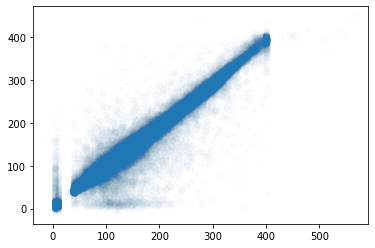

In [66]:
plt.scatter(df['y_true'], df['y_hat'], alpha=0.01)

In [67]:
r2_score(df["y_true"], df["y_hat"])

0.9698983846297271

In [68]:
mse = mean_squared_error(df["y_true"], df["y_hat"])
print(np.sqrt(mse))

8.830021


In [69]:
mean_absolute_percentage_error(df["y_true"], df["y_hat"])

0.03966662

In [70]:
mean_absolute_error(df["y_true"], df["y_hat"])

4.812114

## Misc

In [ ]:
# Can be useful for loading a net thats been passed to DataParallel
from collections import OrderedDict
state_dict = torch.load(os.path.join(SAVE_DIR, save_string))
new_state_dict= OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name]=v